## File handling

This notebook discusses how work with py4DSTEM files, including saving, loading, and copying.  It has 4 parts:

1. Searching DataObjects
2. Saving py4DSTEM files
3. Loading py4DSTEM files
4. Adding to, copying, or removing objects from py4DSTEM files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM
from py4DSTEM.file.datastructure import DataCube, DiffractionSlice, RealSlice, PointList, PointListArray

#### Make some DataObjects

In [2]:
# Before getting into saving a loading, we'll quickly generate a few different DataObject storing data
# we want to save.

# Don't worry too much about this cell - its essentially a very condensed version of all the code from
# the notebook dataobject.ipynb.  Check that notebook out for more discussion about how we're generating these
# DataObjects.

################ Skip the rest of this cell! ###################

# Load, reshape and name a datacube
fp = "/home/ben/Data/20180830_zeltman_smallsampledatasets/1_10x10 ss=100 alpha=p48 spot 11 cl=1200 300kV RT bin=4 0p5sec.dm3"
datacube = py4DSTEM.file.io.read(fp)
datacube.set_scan_shape(10,10)
datacube.name = 'sample_datacube'

# Diffraction slice with one diffraction pattern
diffractionslice1 = DiffractionSlice(data=datacube.data[5,5,:,:])

# Real slice with an average image
realslice1 = RealSlice(data=np.average(datacube.data,axis=(2,3)), name='average_image')

# Pointlist storing a few scan positions
scan_positions = ((0,4),(3,3),(8,7))
coordinates = [('Rx',int), ('Ry',int)]
pointlist = PointList(coordinates=coordinates)
for (x,y) in scan_positions:
    pointlist.add_point((x,y))

# PointListArray of a handful of random points in each diffraction pattern.
coords = [('Qx',float),('Qy',float)]
shape = (datacube.R_Nx, datacube.R_Ny)
pointlistarray = PointListArray(coordinates=coords, shape=shape, name="random_points")
for Rx in range(datacube.R_Nx):
    for Ry in range(datacube.R_Ny):
        current_pointlist = pointlistarray.get_pointlist(Rx,Ry)
        for i in range(10):
            current_pointlist.add_point(np.random.random(2)*np.array([datacube.Q_Nx,datacube.Q_Ny]))
            
# Diffraction slice with three diffraction patterns
data = np.zeros((datacube.Q_Nx,datacube.Q_Ny,3))
data[:,:,0] = datacube.data[0,3,:,:]
data[:,:,1] = datacube.data[5,4,:,:]
data[:,:,2] = datacube.data[3,7,:,:]
diffractionslice2 = DiffractionSlice(data=data, name='three_diffraction_patterns')

# Real slice with 4 images - BF, ADF, CoM_x, CoM_y
BF_R,ADF_R_inner,ADF_R_outer,CoM_R = 10,100,200,200
x0,y0 = py4DSTEM.process.utils.get_CoM(np.average(datacube.data,axis=(0,1)))
data = np.zeros((datacube.R_Nx,datacube.R_Ny,4))
data[:,:,0]=datacube.get_virtual_image_circ_integrate(slice(int(x0)-BF_R,int(x0)+BF_R),slice(int(y0)-BF_R,int(y0)+BF_R))[0]
data[:,:,1]=datacube.get_virtual_image_annular_integrate((slice(int(x0)-ADF_R_outer,int(x0)+ADF_R_outer)),(slice(int(y0)-ADF_R_outer,int(y0)+ADF_R_outer)),ADF_R_outer/ADF_R_inner)[0]
data[:,:,2]=datacube.get_virtual_image_circ_CoMX((slice(int(x0)-CoM_R,int(x0)+CoM_R)),(slice(int(y0)-CoM_R,int(y0)+CoM_R)))[0]
data[:,:,3]=datacube.get_virtual_image_circ_CoMY((slice(int(x0)-CoM_R,int(x0)+CoM_R)),(slice(int(y0)-CoM_R,int(y0)+CoM_R)))[0]
realslice2 = RealSlice(data=data, name='virtual_images',
                       slicelabels=('BF','ADF','CoM_x','CoM_y'))

/home/ben/Data/20180830_zeltman_smallsampledatasets/1_10x10 ss=100 alpha=p48 spot 11 cl=1200 300kV RT bin=4 0p5sec.dm3 is not a py4DSTEM file.
Reading with hyperspy...


In [3]:
# We now have the following seven DataObjects, containing data we might like to save

print(datacube)
print(diffractionslice1)
print(diffractionslice2)
print(realslice1)
print(realslice2)
print(pointlist)
print(pointlistarray)

### Part 1: Searching DataObjects

Before saving data, we need an interface for finding and referring to the data we have stored in memory.
Searching DataObjects is accomplished using the DataObject class methods, demonstrated below.

In [4]:
# Import the DataObject class.

from py4DSTEM.file.datastructure import DataObject

In [5]:
# List all dataobjects

DataObject.get_dataobjects()

In [6]:
# List all DataObjects, in human-readable format
# Notice that, in addition to the seven DataObjects we explicitly defined, there is a Metadata type object at
# index zero.  Metadata objects and metadata handling are discussed in more detail in the notebook metadata.ipynb.

DataObject.show_dataobjects()

 Index                  Name                        Type        
   0                                        Metadata            
   1    sample_datacube                     DataCube            
   2                                        DiffractionSlice    
   3    average_image                       RealSlice           
   4                                        PointList           
   5    random_points                       PointListArray      
   6    three_diffraction_patterns          DiffractionSlice    
   7    virtual_images                      RealSlice           


In [7]:
# Or, equivalently:

DataObject.get_dataobject_list(show=True)

 Index                  Name                        Type        
   0                                        Metadata            
   1    sample_datacube                     DataCube            
   2                                        DiffractionSlice    
   3    average_image                       RealSlice           
   4                                        PointList           
   5    random_points                       PointListArray      
   6    three_diffraction_patterns          DiffractionSlice    
   7    virtual_images                      RealSlice           


In [8]:
# Sort the DataObjects by name
# Lists objects we've given names to first; adding names to import DataObjects is recommended!

DataObject.sort_dataobjects_by_name(show=True)

 Index                  Name                        Type        
   1    sample_datacube                     DataCube            
   3    average_image                       RealSlice           
   5    random_points                       PointListArray      
   6    three_diffraction_patterns          DiffractionSlice    
   7    virtual_images                      RealSlice           
   0                                        Metadata            
   2                                        DiffractionSlice    
   4                                        PointList           


In [9]:
# Sort the DataObjects by type

DataObject.sort_dataobjects_by_type(show=True)

 Index                  Name                        Type        
   0                                        Metadata            
   1    sample_datacube                     DataCube            
   2                                        DiffractionSlice    
   6    three_diffraction_patterns          DiffractionSlice    
   3    average_image                       RealSlice           
   7    virtual_images                      RealSlice           
   4                                        PointList           
   5    random_points                       PointListArray      


In [10]:
# Get all DataObjects of a given type

DataObject.get_dataobject_by_type(RealSlice)

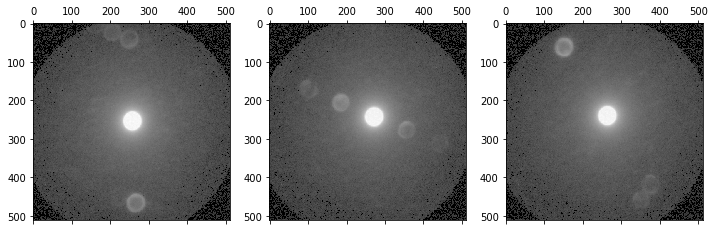

In [11]:
# Get a dataobject by index

three_DPs = DataObject.get_dataobject_by_index(6)

# Show
power=0.2
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,6))
ax1.matshow(three_DPs.data[:,:,0]**power)
ax2.matshow(three_DPs.data[:,:,1]**power)
ax3.matshow(three_DPs.data[:,:,2]**power)
plt.show()

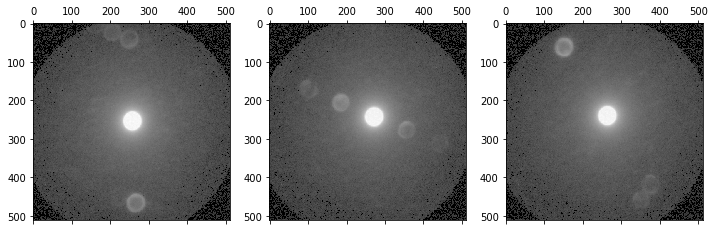

In [12]:
# Get a dataobject by name
# Note that this returns a list, containing however many objects match the search criterion

three_DPs = DataObject.get_dataobject_by_name('three_diffraction_patterns')[0]  # The [0] grabs the first element of the list

# Show
power=0.2
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,6))
ax1.matshow(three_DPs.data[:,:,0]**power)
ax2.matshow(three_DPs.data[:,:,1]**power)
ax3.matshow(three_DPs.data[:,:,2]**power)
plt.show()

In [13]:
# When we querry dataobjects by name, the default behavior is to return all objects with names
# containing our search string.  Here, we had two objects with names containing "image":

DataObject.get_dataobject_by_name('image')

In [14]:
# We can also search only for exact matches

DataObject.get_dataobject_by_name('image', exactmatch=True)

[]

### Part 2: Saving py4DSTEM files

The py4DSTEM save() function has a few distinct use cases, described here.

Note that the py4DSTEM file format is HDF5 based, so generally the file extension of choice is '.h5'.
HDF5 ("heirarchical data format") is a versatile file format for handling large scale datasets - you can find more information at, e.g. https://support.hdfgroup.org/HDF5/whatishdf5.html.
This also means that you can always read py4DSTEM files directly as generic .h5 files; in python, for instance, you can use the h5py package.

In [15]:
# Import the save function

from py4DSTEM.file.io import save

In [16]:
# We'll demonstrate saving data a few different ways
# In each case we'll refer back to the list of DataObjects available in memory

DataObject.show_dataobjects()

 Index                  Name                        Type        
   0                                        Metadata            
   1    sample_datacube                     DataCube            
   2                                        DiffractionSlice    
   3    average_image                       RealSlice           
   4                                        PointList           
   5    random_points                       PointListArray      
   6    three_diffraction_patterns          DiffractionSlice    
   7    virtual_images                      RealSlice           


#### Single dataobject

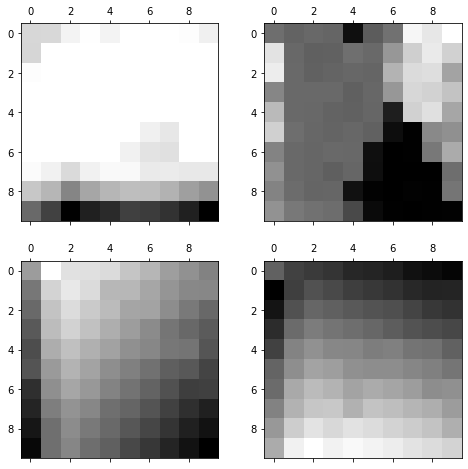

In [17]:
# Let's just save the RealSlice object containing the collection of virtual images.
# First we'll retrieve it

images = DataObject.get_dataobject_by_name('virtual_images')[0]

# Show
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(8,8))
ax11.matshow(images.slices['BF'])
ax12.matshow(images.slices['ADF'])
ax21.matshow(images.slices['CoM_x'])
ax22.matshow(images.slices['CoM_y'])
plt.show()

In [18]:
# Save

filepath="/home/ben/Desktop/single_DataObject.h5"
save(images,filepath)

Creating file /home/ben/Desktop/single_DataObject.h5...
Writing metadata...
Done.


#### Single DataObject, from index

In [19]:
# Let's save the same object, this time selecting it using its index in the DataObject list above.
# Looking at the output of DataObject.show_dataobjects(),
# I find the RealSlice named "virtual_images" has index 7

filepath="/home/ben/Desktop/single_DataObject_from_index.h5"
save(7,filepath)

Creating file /home/ben/Desktop/single_DataObject_from_index.h5...
Writing metadata...
Done.


#### Many DataObjects

In [20]:
# To save a whole group of DataObjects, we can pass the save() function a list of the DataObjects of interest
# Lets save all the real and diffraction slice objects

realslices = DataObject.get_dataobject_by_type(RealSlice)
diffractionslices = DataObject.get_dataobject_by_type(DiffractionSlice)

dataobjects = realslices + diffractionslices

filepath="/home/ben/Desktop/multiple_DataObjects.h5"
save(dataobjects,filepath)

Creating file /home/ben/Desktop/multiple_DataObjects.h5...
Writing metadata...
Done.


#### Many DataObjects, from indices

In [21]:
# If we want to save a more eclectic assortment of objects,
# we can do so by specifying their indices in the list from DataObject.show_dataobjects().

filepath="/home/ben/Desktop/multiple_DataObjects_from_indices.h5"
save([3,4,7],filepath)

Creating file /home/ben/Desktop/multiple_DataObjects_from_indices.h5...
Writing metadata...
Done.


#### All DataObjects

In [22]:
# We can also just save all the DataObjects in memory.
# A little caution may be in order here, as the DataObjects generated by a single session can proliferate quickly!

# In particular, note that if we have a block of code like
#          diffslice = DiffractionSlice(data)
# and we run it twice, this mean there will be two, potentially identical, DiffractionSlice objects now in memory
# (though the variable diffslice only points to the most recently created one).
# It may be worth quickly checking DataObject.show_dataobjects() before saving everything.

filepath="/home/ben/Desktop/all_DataObjects.h5"
save('all',filepath)


Creating file /home/ben/Desktop/all_DataObjects.h5...
Writing metadata...
Done.


### Part 3: Loading py4DSTEM files

Here, we demo loading files two ways: 

1. with the read() function, and
2. with the FileBrowser class.

In [23]:
# Imports

from py4DSTEM.file.io import read
from py4DSTEM.file.io import FileBrowser

#### Loading data with read()

Using read() is a much more lightweight approach to loading data than using the FileBrowser class, and is the easiest approach when:

1. There is only one dataobject in a file
2. You know in advance the name of the object you need (e.g. for scripting)
3. You just want to load all the DataObjects at once

In [24]:
# Read the first DataObject in a file

filepath = "/home/ben/Desktop/all_DataObjects.h5"
data = read(filepath)

print('\n')
print(data)

/home/ben/Desktop/all_DataObjects.h5 is a py4DSTEM file, v0.3. Reading...




In [25]:
# Read all the DataObjects in a file

filepath = "/home/ben/Desktop/all_DataObjects.h5"
data = read(filepath, load='all')

print('\n')
for dataobject in data:
    print(dataobject)

/home/ben/Desktop/all_DataObjects.h5 is a py4DSTEM file, v0.3. Reading...




In [26]:
# Read a dataobject with a known name

filepath = "/home/ben/Desktop/all_DataObjects.h5"
data = read(filepath, load='virtual_images')

print('\n')
print(dataobject)

/home/ben/Desktop/all_DataObjects.h5 is a py4DSTEM file, v0.3. Reading...




In [27]:
# Read a dataobject with a known index in the py4DSTEM file
# Indices can be determined using a FileBrowser; see below.

filepath = "/home/ben/Desktop/all_DataObjects.h5"
data = read(filepath, load=2)

print('\n')
print(data)

/home/ben/Desktop/all_DataObjects.h5 is a py4DSTEM file, v0.3. Reading...




In [28]:
# Read a group dataobject with known indices

filepath = "/home/ben/Desktop/all_DataObjects.h5"
data = read(filepath, load=[2,3,5])

print('\n')
for dataobject in data:
    print(dataobject)

/home/ben/Desktop/all_DataObjects.h5 is a py4DSTEM file, v0.3. Reading...




In [29]:
# By the way, the read() function also handles many non-py4DSTEM file formats
# For these, it uses the i/o functionality of the excellent hyperspy package (http://hyperspy.org/), and
# attempts to return a DataCube, if possible

# Load a datacube
fp = "/home/ben/Data/20180830_zeltman_smallsampledatasets/1_10x10 ss=100 alpha=p48 spot 11 cl=1200 300kV RT bin=4 0p5sec.dm3"
another_datacube = read(fp)

/home/ben/Data/20180830_zeltman_smallsampledatasets/1_10x10 ss=100 alpha=p48 spot 11 cl=1200 300kV RT bin=4 0p5sec.dm3 is not a py4DSTEM file.
Reading with hyperspy...


#### Loading data with a FileBrowser

Using a FileBrowser is useful when you have a py4DSTEM file containing many different pieces of data.
A FileBrowser instance allows us to quickly examine what's in a py4DSTEM file before loading the (potentially large amount of) data into memory, look at some of the attributes of the different DataObjects, and select what
we want to load.

Here, we demo using a FileBrowser to:
1. Display and search the contents of a py4DSTEM file
2. Loading some or all of the data in a py4DSTEM file

*1. Display/search py4DSTEM file contents*

In [30]:
# Create a FileBrowser to examine a py4DSTEM file

filepath = "/home/ben/Desktop/all_DataObjects.h5"
browser = FileBrowser(filepath)

In [31]:
# Show its DataObjects

browser.show_dataobjects()

 Index                  Name                        Type        
   0    sample_datacube                     DataCube            
   1    diffractionslice_0                  DiffractionSlice    
   2    three_diffraction_patterns          DiffractionSlice    
   3    average_image                       RealSlice           
   4    virtual_images                      RealSlice           
   5    pointlist_0                         PointList           
   6    random_points                       PointListArray      


In [32]:
# These methods can help streamline sifting through the data in a file:

browser.show_datacubes()
browser.show_diffractionslices()
browser.show_realslices()
browser.show_pointlists()
browser.show_dataobjects(objecttype='DiffractionSlice')

 Index                  Name                       Shape        
   0    sample_datacube                      (10, 10, 512, 512) 
 Index                  Name                  Depth          Shape        
   1    diffractionslice_0                      1          (512, 512)     
   2    three_diffraction_patterns              3          (512, 512)     
 Index                  Name                  Depth          Shape        
   3    average_image                           1           (10, 10)      
   4    virtual_images                          4           (10, 10)      
 Index                  Name                 Length       Coordinates       
   5    pointlist_0                            3          ['Rx', 'Ry']      
 Index                  Name                  Depth          Shape        
   1    diffractionslice_0                      1          (512, 512)     
   2    three_diffraction_patterns              3          (512, 512)     


In [33]:
# Or to get more detailed information about a single object:

browser.show_dataobject(4)

Type    : RealSlice                                         
Name    : virtual_images                                    
Depth   : 4                                                 
Slices  : ['ADF', 'BF', 'CoM_x', 'CoM_y']                   
Shape   : (10, 10)                                          
Index   : 4                                                 


*2. Load data from a FileBrowser*

In [34]:
# Load a single dataobject

virtualimages = browser.get_dataobject(4)

print(virtualimages)

In [35]:
# Load a few dataobjects, by indices

DPs, ave_im, points = browser.get_dataobjects([2,3,5])

print(DPs)
print(ave_im)
print(points)

In [36]:
# These methods retrieve all the objects of a particular type:

browser.get_datacubes()
browser.get_diffractionslices()
browser.get_realslices()
browser.get_pointlists()
browser.get_pointlistarrays()

In [37]:
# Get all the dataobjects

dataobjects = browser.get_dataobjects('all')

for dataobject in dataobjects:
    print(dataobject)

In [38]:
# Get a dataobject by name

dataobjects = browser.get_dataobject_by_name(name='virtual_images')

print(dataobjects)

In [39]:
# The default behavior for this method is that queried name and object names must be an exact match
# To find all objects containing name as a substring, set the exactmatch keyword to False

browser.get_dataobject_by_name(name='image', exactmatch=False)

### Part 4: Appending to, copying from, and removing objects from existing py4DSTEM files

In this section we demo appending additional DataObjects to an existing py4DSTEM file, copying entire files, and removing dataobjects from files.

In [40]:
from py4DSTEM.file.io import append
from py4DSTEM.file.io import copy
from py4DSTEM.file.io import remove

#### Append

A word of warning: when you save a *new* file, py4DSTEM saves the associated metadata with it.
When you add new data to an existing file, unless you specifically instruct py4DSTEM otherwise, the metadata will not change.  This means you could, for instance, add a new Datacube, DiffractionSlice, or RealSlice to a file with existing pixel calibrations in its metadata - possibly the wrong pixel calibrations, if you're not careful.  So be careful!

More discussion of metadata handling may be found in notebooks/basic_demos/metadata.ipynb.

In [41]:
# Make some new dataobjects to add to a file

new_datacube = DataCube(data=np.random.random(size=(5,5,20,20)))
new_realslice = RealSlice(data=np.random.random(size=(datacube.R_Nx,datacube.R_Ny)), name='new_data')
new_diffslice = DiffractionSlice(data=np.random.random(size=(datacube.Q_Nx,datacube.Q_Ny)), name='new_data')

# Pointlist storing a few scan positions
coordinates = [('Rx',int), ('Ry',int)]
new_pointlist = PointList(coordinates=coordinates)
for x in np.arange(10):
    for y in np.arange(10):
        new_pointlist.add_point((x,y))

# PointListArray of a handful of random points in each diffraction pattern.
coords = [('Qx',float),('Qy',float)]
shape = (datacube.R_Nx, datacube.R_Ny)
new_pointlistarray = PointListArray(coordinates=coords, shape=shape, name="random_points")
for Rx in range(datacube.R_Nx):
    for Ry in range(datacube.R_Ny):
        current_pointlist = new_pointlistarray.get_pointlist(Rx,Ry)
        for i in range(5):
            current_pointlist.add_point(np.random.random(2)*np.array([datacube.Q_Nx,datacube.Q_Ny]))

In [42]:
# Make a FileBrowser for a file

filepath = "/home/ben/Desktop/all_DataObjects.h5"
browser = FileBrowser(filepath)

In [43]:
# Show existing objects

browser.show_dataobjects()
browser.close()              # This closes the .h5 file which browser is reading.
                             # We need to do this before appending, so that the append function can open the file
                             # (with different read/write permissions)

 Index                  Name                        Type        
   0    sample_datacube                     DataCube            
   1    diffractionslice_0                  DiffractionSlice    
   2    three_diffraction_patterns          DiffractionSlice    
   3    average_image                       RealSlice           
   4    virtual_images                      RealSlice           
   5    pointlist_0                         PointList           
   6    random_points                       PointListArray      


In [44]:
# Append a new DataObject to the existing file

filepath = "/home/ben/Desktop/all_DataObjects.h5"
append(new_realslice, filepath)

Opening file /home/ben/Desktop/all_DataObjects.h5...
Done.


In [45]:
# Show existing objects - there should now be a new dataobject present

browser.open()             # Becuase we closed the .h5 file above, we need to re-open it for the browser to read it
browser.reload()           # This tells browser to look through the file and update its list of objects it finds
browser.show_dataobjects()    
browser.close()

 Index                  Name                        Type        
   0    sample_datacube                     DataCube            
   1    diffractionslice_0                  DiffractionSlice    
   2    three_diffraction_patterns          DiffractionSlice    
   3    average_image                       RealSlice           
   4    new_data                            RealSlice           
   5    virtual_images                      RealSlice           
   6    pointlist_0                         PointList           
   7    random_points                       PointListArray      


In [46]:
# Append several new DataObject to the existing file

new_dataobjects = [new_datacube, new_diffslice, new_pointlist, new_pointlistarray]

filepath = "/home/ben/Desktop/all_DataObjects.h5"
append(new_dataobjects, filepath)

Opening file /home/ben/Desktop/all_DataObjects.h5...
Done.


In [47]:
# Show
# Note that any repeated DataObject names will have a "_#" appended to the end of their names for uniqueness

browser.open()
browser.reload()
browser.show_dataobjects()    
browser.close()

 Index                  Name                        Type        
   0    datacube_1                          DataCube            
   1    sample_datacube                     DataCube            
   2    diffractionslice_0                  DiffractionSlice    
   3    new_data                            DiffractionSlice    
   4    three_diffraction_patterns          DiffractionSlice    
   5    average_image                       RealSlice           
   6    new_data                            RealSlice           
   7    virtual_images                      RealSlice           
   8    pointlist_0                         PointList           
   9    pointlist_1                         PointList           
   10   random_points                       PointListArray      
   11   random_points_1                     PointListArray      


In [48]:
# The interface for appending is nearly the same as that for saving,
# i.e. you can also append dataobjects by their indices in DataObject.show_dataobjects

DataObject.show_dataobjects()  # Show all dataobjects in memory

 Index                  Name                        Type        
   0                                        Metadata            
   1    sample_datacube                     DataCube            
   2                                        DiffractionSlice    
   3    average_image                       RealSlice           
   4                                        PointList           
   5    random_points                       PointListArray      
   6    three_diffraction_patterns          DiffractionSlice    
   7    virtual_images                      RealSlice           
   8    three_diffraction_patterns          DiffractionSlice    
   9    average_image                       RealSlice           
   10   pointlist_0                         PointList           
   11                                       Metadata            
   12                                       DataCube            
   13   virtual_images                      RealSlice           
   14   three_diffraction

In [49]:
# Let's append a few of these to the file we made with just a single dataobject

filepath = "/home/ben/Desktop/single_DataObject.h5"
browser = FileBrowser(filepath)
browser.show_dataobjects()
browser.close()

 Index                  Name                        Type        
   0    virtual_images                      RealSlice           


In [50]:
# Append a few of them to an .h5 file

append([8,3,23], filepath)

Opening file /home/ben/Desktop/single_DataObject.h5...
Done.


In [51]:
# Show

browser.open()
browser.reload()
browser.show_dataobjects()
browser.close()

 Index                  Name                        Type        
   0    three_diffraction_patterns          DiffractionSlice    
   1    average_image                       RealSlice           
   2    new_data                            RealSlice           
   3    virtual_images                      RealSlice           


#### Copy

In [52]:
# Examine a file

original_filepath = "/home/ben/Desktop/all_DataObjects.h5"
browser = FileBrowser(original_filepath)
browser.show_dataobjects()
browser.close()

 Index                  Name                        Type        
   0    datacube_1                          DataCube            
   1    sample_datacube                     DataCube            
   2    diffractionslice_0                  DiffractionSlice    
   3    new_data                            DiffractionSlice    
   4    three_diffraction_patterns          DiffractionSlice    
   5    average_image                       RealSlice           
   6    new_data                            RealSlice           
   7    virtual_images                      RealSlice           
   8    pointlist_0                         PointList           
   9    pointlist_1                         PointList           
   10   random_points                       PointListArray      
   11   random_points_1                     PointListArray      


In [58]:
# Copy the whole file

new_filepath = "/home/ben/Desktop/copy_all.h5"
copy(original_filepath, new_filepath, 'all')

# Show
browser = FileBrowser(new_filepath)
browser.show_dataobjects()
browser.close()

Creating file /home/ben/Desktop/copy_all.h5...
Done.
 Index                  Name                        Type        
   0    datacube_1                          DataCube            
   1    sample_datacube                     DataCube            
   2    diffractionslice_0                  DiffractionSlice    
   3    new_data                            DiffractionSlice    
   4    three_diffraction_patterns          DiffractionSlice    
   5    average_image                       RealSlice           
   6    new_data                            RealSlice           
   7    virtual_images                      RealSlice           
   8    pointlist_0                         PointList           
   9    pointlist_1                         PointList           
   10   random_points                       PointListArray      
   11   random_points_1                     PointListArray      


#### Remove

In [59]:
# Examine file contents

fp = "/home/ben/Desktop/copy_all.h5"

# Show
browser = FileBrowser(fp)
browser.show_dataobjects()
browser.close()

 Index                  Name                        Type        
   0    datacube_1                          DataCube            
   1    sample_datacube                     DataCube            
   2    diffractionslice_0                  DiffractionSlice    
   3    new_data                            DiffractionSlice    
   4    three_diffraction_patterns          DiffractionSlice    
   5    average_image                       RealSlice           
   6    new_data                            RealSlice           
   7    virtual_images                      RealSlice           
   8    pointlist_0                         PointList           
   9    pointlist_1                         PointList           
   10   random_points                       PointListArray      
   11   random_points_1                     PointListArray      


In [60]:
# Remove one DataObject

remove(6,fp)

# Show
browser = FileBrowser(fp)
browser.show_dataobjects()
browser.close()

Opening file /home/ben/Desktop/copy_all.h5...
Done.
 Index                  Name                        Type        
   0    datacube_1                          DataCube            
   1    sample_datacube                     DataCube            
   2    diffractionslice_0                  DiffractionSlice    
   3    new_data                            DiffractionSlice    
   4    three_diffraction_patterns          DiffractionSlice    
   5    average_image                       RealSlice           
   6    virtual_images                      RealSlice           
   7    pointlist_0                         PointList           
   8    pointlist_1                         PointList           
   9    random_points                       PointListArray      
   10   random_points_1                     PointListArray      


In [61]:
# Remove several DataObjects

remove([1,2,10],fp)

# Show
browser = FileBrowser(fp)
browser.show_dataobjects()
browser.close()

Opening file /home/ben/Desktop/copy_all.h5...
Done.
 Index                  Name                        Type        
   0    datacube_1                          DataCube            
   1    new_data                            DiffractionSlice    
   2    three_diffraction_patterns          DiffractionSlice    
   3    average_image                       RealSlice           
   4    virtual_images                      RealSlice           
   5    pointlist_0                         PointList           
   6    pointlist_1                         PointList           
   7    random_points                       PointListArray      
